In [1]:
# @title Dependencies
import torch
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cpu


In [2]:
# @title Model definition { display-mode: "form" }

# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
# Repacing last 1k classes linear layer with 2 classes layer
# model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=2)

from torch import nn

class ClassifierModel(nn.Module):
  def __init__(self):
    super(ClassifierModel, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,16, kernel_size=(2,2)), # 512x512x3xN --> 510x510x64xN, rf = 3x3 32-> 16
        nn.MaxPool2d(kernel_size=2, stride=2), # 510x510x64xN --> 255x255x64xN
        nn.ReLU(),
        nn.Conv2d(16,128, kernel_size=(2,2)),  # 255x255x64xN --> 252x252x128xN, rf = 6x6 16-> 8
        nn.AvgPool2d(kernel_size=2, stride=2), # 252x252x128xN --> 126x126x128xN
        nn.ReLU(),
        nn.Conv2d(128,64, kernel_size=(3,3)), # 126x126x128xN --> 124x124x64xN, rf = 8x8
        nn.MaxPool2d(kernel_size=2, stride=2), # 124x124x64xN --> 62x62x64xN
        nn.ReLU(),
        nn.Conv2d(64,16, kernel_size=(3,3)), # 62x62x64xN --> 61x61x16xN, rf = 10x10
        nn.MaxPool2d(kernel_size=2, stride=2), # 60x60x16xN --> 30x30x16xN
        nn.ReLU(),
    )
    self.converter = nn.Flatten() # 30x30x16xN --> 14400 params
    self.classifier = nn.Sequential(
        nn.Linear(in_features=1600, out_features=4096),
        nn.Sigmoid(),
        nn.Linear(in_features=4096, out_features=2048),
        nn.Sigmoid(),
        nn.Linear(in_features=2048, out_features=512),
        nn.Sigmoid(),
        nn.Linear(in_features=512, out_features=128),
        nn.Sigmoid(),
        nn.Linear(in_features=128, out_features=32),
        nn.Sigmoid(),
        nn.Linear(in_features=32, out_features=8),
        nn.Sigmoid(),
        nn.Linear(in_features=8, out_features=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.features(x)
    x = self.converter(x)
    x = self.classifier(x)
    return x

In [33]:
from datasets import load_dataset
from transformers import AutoImageProcessor
dataset = load_dataset("mvkvc/artifact-100k") # subset of ArtiFact labled with "ai" and "real" tags

dataset = dataset.with_format(type="torch", device=device)

image_processor = AutoImageProcessor.from_pretrained("umm-maybe/AI-image-detector")

batch_size = 1

train_loader = torch.utils.data.DataLoader(dataset=dataset["train"], batch_size=batch_size,  num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset["test"], batch_size=batch_size, num_workers=2, shuffle=True)

/home/t1/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [38]:
a = 0
b = 0

for data in train_loader:
    print(data["image"].shape)
    break
print(a, b)

torch.Size([1, 3, 200, 200])
0 0


In [29]:
import torch.optim as optim

model = ClassifierModel()
model.load_state_dict(torch.load('./models/alexnetartifact100k', map_location=device))
model.to(device)

ClassifierModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ReLU()
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (converter): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2048, out_features=512, bias=True)
    (5): Sigmoid()
    (6): Linear(in_

In [30]:
y_target = []
y_score = []

mx = 100

for batch_ind, data in enumerate(train_loader):
    mx -= 1
    inputs, targets = data['image'], data['label']
    inputs = inputs.to(torch.float).to(device)
    output = model(inputs)
    
    y_target += list(targets.numpy())
    y_score += list(output[:,1].detach().numpy())
    if mx < 0:
        break
print('done.')

done.


In [31]:
for i in range(len(y_target)):
    print(y_target[i], y_score[i])

1 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
0 0.015438802
1 0.015438802
1 0.015438802
1 0.01

0.5


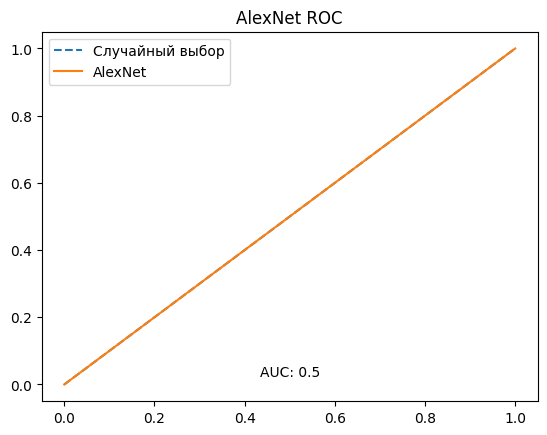

In [39]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

fpr, tpr, thresholds = metrics.roc_curve(y_target, y_score)
auc = metrics.roc_auc_score(y_target, y_score)
auc_text = f"AUC: {round(auc,3)}"
print(auc)

plt.title("AlexNet ROC")
plt.plot([0,1],[0,1], label="Случайный выбор", linestyle="dashed")
plt.plot(fpr,tpr, label="AlexNet")
plt.text(0.5,0.025,auc_text, horizontalalignment="center")
plt.legend()

In [ ]:
with open("./alex_roc.npy", "wb") as f:
    np.save(f,np.row_stack((fpr,tpr)))